## Setup Libraries

In [53]:
import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

In [54]:
# load from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load the Raw Data

Fungsi berikut dijalankan untuk memeberikan hasil gambar asli dari dataset yang diambil secara acak dan data csv berupa narasi cerita

In [74]:
# Data Images
def load_images(directory):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        try:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert('RGB')
            images.append(img)
            filenames.append(filename)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    return images, filenames

Total gambar karmawibhangga: 160


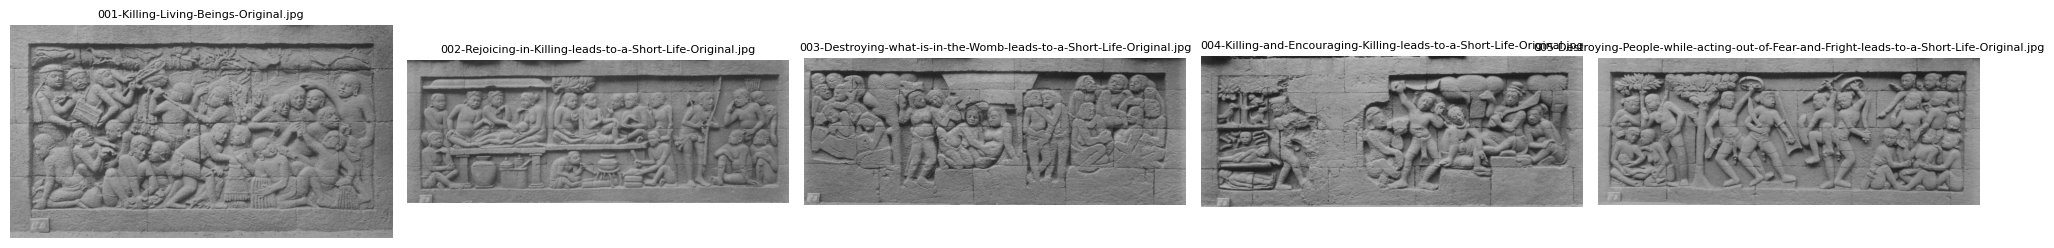

In [75]:
# Inisiasi path folder dataset
IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/Capstone/image all"
images, filenames = load_images(IMAGE_DIR)

# Hasil total gambar karmawibhangga
print(f"Total gambar karmawibhangga: {len(images)}")

# Menampilkan visualisasi gambar yang diambil 5 acak dari IMAGE DIR
plt.figure(figsize=(20, 10))
for i in range(min(5, len(images))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(filenames[i], fontsize=8)
plt.tight_layout()
plt.show()

## Data Exploration

**Explore image** Informasi yang sudah didapatkan saat melakuakn laod raw data gambar, ada total **160 gambar** relief karmawibhangga, tidak ada file rusak dan kosong, informasi lain adalah resolusi gambar yang berbeda beda


In [58]:
# menghitung jumlah resolusi gambar
def count_image_by_resolution_flat(IMAGE_DIR):
    resolution_counts = defaultdict(int)

    for image_name in os.listdir(IMAGE_DIR):
        image_path = os.path.join(IMAGE_DIR, image_name)
        if os.path.isfile(image_path):
            try:
                with Image.open(image_path) as img:
                    resolution = img.size  # (width, height)
                    resolution_counts[resolution] += 1
            except Exception as e:
                print(f"Gagal membaca {image_path}: {e}")

    print("\nJumlah gambar berdasarkan resolusi:")
    for resolution, count in resolution_counts.items():
        print(f"- {resolution}: {count} gambar")

    return resolution_counts

# Contoh panggilan fungsi
count_image_by_resolution_flat(IMAGE_DIR)


Jumlah gambar berdasarkan resolusi:
- (1889, 1051): 1 gambar
- (2002, 751): 1 gambar
- (1943, 746): 1 gambar
- (1943, 768): 1 gambar
- (1981, 764): 1 gambar
- (1971, 744): 1 gambar
- (1990, 767): 1 gambar
- (1985, 701): 1 gambar
- (1979, 731): 1 gambar
- (2471, 902): 1 gambar
- (2362, 896): 1 gambar
- (2440, 855): 1 gambar
- (2527, 852): 1 gambar
- (1964, 797): 1 gambar
- (2383, 854): 1 gambar
- (2354, 834): 1 gambar
- (1934, 696): 1 gambar
- (1929, 710): 1 gambar
- (7130, 2329): 1 gambar
- (7031, 2427): 1 gambar
- (3169, 1088): 1 gambar
- (3085, 1008): 1 gambar
- (1936, 760): 1 gambar
- (1962, 754): 1 gambar
- (2139, 840): 1 gambar
- (1951, 795): 1 gambar
- (1894, 734): 1 gambar
- (1912, 720): 1 gambar
- (1963, 705): 1 gambar
- (1873, 777): 1 gambar
- (1996, 749): 1 gambar
- (1980, 741): 1 gambar
- (1954, 776): 1 gambar
- (1935, 831): 1 gambar
- (1992, 768): 1 gambar
- (1940, 804): 1 gambar
- (2014, 826): 1 gambar
- (1984, 816): 1 gambar
- (1767, 755): 1 gambar
- (2010, 853): 1 gamba

defaultdict(int,
            {(1889, 1051): 1,
             (2002, 751): 1,
             (1943, 746): 1,
             (1943, 768): 1,
             (1981, 764): 1,
             (1971, 744): 1,
             (1990, 767): 1,
             (1985, 701): 1,
             (1979, 731): 1,
             (2471, 902): 1,
             (2362, 896): 1,
             (2440, 855): 1,
             (2527, 852): 1,
             (1964, 797): 1,
             (2383, 854): 1,
             (2354, 834): 1,
             (1934, 696): 1,
             (1929, 710): 1,
             (7130, 2329): 1,
             (7031, 2427): 1,
             (3169, 1088): 1,
             (3085, 1008): 1,
             (1936, 760): 1,
             (1962, 754): 1,
             (2139, 840): 1,
             (1951, 795): 1,
             (1894, 734): 1,
             (1912, 720): 1,
             (1963, 705): 1,
             (1873, 777): 1,
             (1996, 749): 1,
             (1980, 741): 1,
             (1954, 776): 1,
             (1935, 8

Karena dataset relatif kecil maka kami bisa langsung melihat dan menganalisis secara manual mengenai kondisi dataset ini, ternyata dataset yang missing value memiliki bentuk gambar yang tidak bisa diartikan/ ukirannya memang tidak jelas. sehingga pada tahapan selanjutnya kami tidak akan menghapus data tersebut, namun menambahkan keterangan bahwa gambar tersebut tidak adapat diartikan

## Data Preparation

Data yang akan digunakan adalah dataset gambar saja dengan menggunakan algoritma **image similarity**
1. Preprocessing gamabr dengan resize gambar, konversi ke array karena akan menggunakan keras tensorflow, dan menyesuaikan skala pixel



In [59]:
image_size = (224, 224)
valid_ext = ['.jpg', '.jpeg', '.png']

def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)  # resize
    img_array = img_to_array(img)                      # convert ke array
    img_array = np.expand_dims(img_array, axis=0)     # tambah dim batch
    img_array = preprocess_input(img_array)            # preprocess ResNet50
    return img_array

image_arrays = []
image_names = []

for filename in os.listdir(IMAGE_DIR):
    if any(filename.lower().endswith(ext) for ext in valid_ext):
        file_path = os.path.join(IMAGE_DIR, filename)
        if os.path.isfile(file_path):
            try:
                img_arr = preprocess_image(file_path, image_size)
                image_arrays.append(img_arr[0])
                image_names.append(filename)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

image_data = np.array(image_arrays)
print(f"Total images processed: {len(image_data)}")
print(f"Shape image_data: {image_data.shape}")

Total images processed: 160
Shape image_data: (160, 224, 224, 3)


gambarnya terlihat aneh (warna aneh, terlalu gelap), itu karena preprocess_input() dari ResNet mengubah nilai piksel menjadi skala khusus. Saat ingin ditampilkan, normalisasi balik dengan (img + 1)/2 atau cukup pakai plt.imshow(img.astype("uint8")) sebelum preprocess_input untuk visualisasi asli.

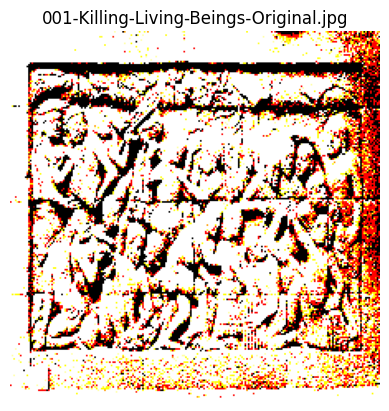

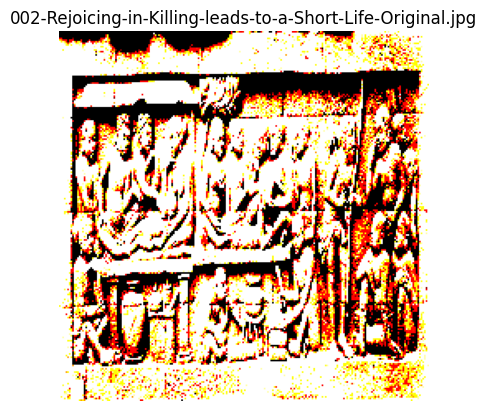

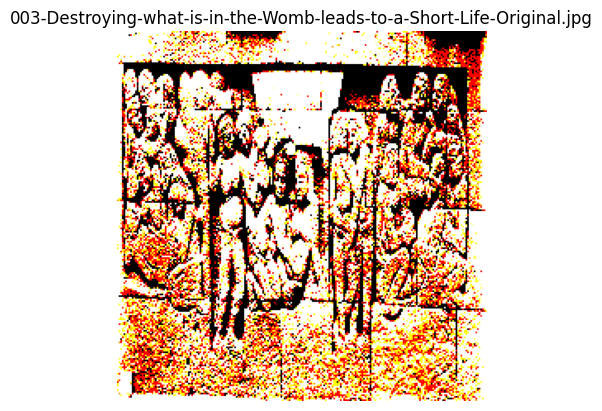

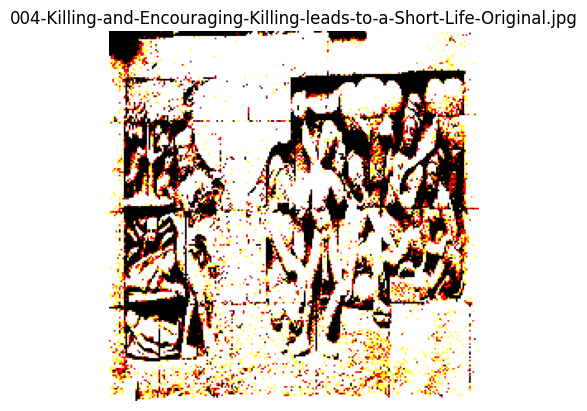

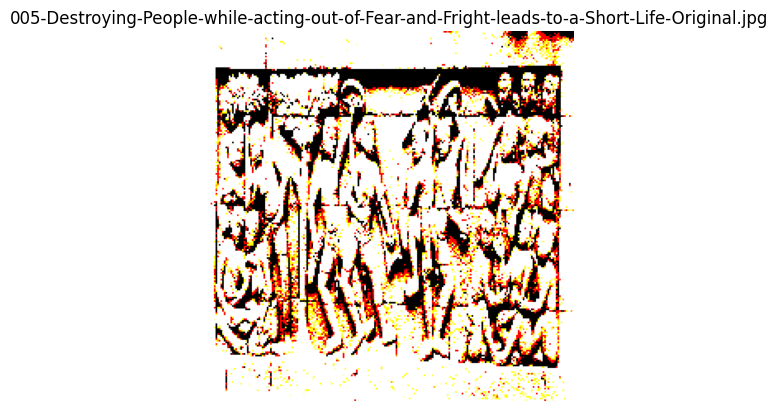

In [60]:
for i in range(5):
    plt.imshow((image_data[i] + 1) / 2)
    plt.title(image_names[i])
    plt.axis('off')
    plt.show()

## Feature Extraction

- Menggunakan model CNN pretrained (ResNet50 tanpa bagian klasifikasi paling atas) sebagai feature extractor.

- Input: image_data → Output: array fitur untuk tiap gambar

- Fitur ini adalah representasi gambar dalam bentuk angka yang bisa dibandingkan satu sama lain.

In [61]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
features = model.predict(image_data, batch_size=32, verbose=1)
print(f"Features shape: {features.shape}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step
Features shape: (160, 2048)


## Save fitur dan nama file

In [62]:
with h5py.File('features.h5', 'w') as h5f:
    h5f.create_dataset('features', data=features)
    # Simpan nama file sebagai string array dan convert ke bytes
    dt = h5py.string_dtype(encoding='utf-8')
    h5f.create_dataset('image_names', data=np.array(image_names, dtype=dt))

In [63]:
# Read data dari H5
with h5py.File('features.h5', 'r') as h5f:
    features = h5f['features'][:]        # baca semua fitur
    image_names = h5f['image_names'][:] # baca semua nama gambar sebagai bytes
    image_names = [name.decode('utf-8') for name in image_names]  # decode ke string

## Similarity Search

- Pada image similarity berbasis feature embedding dengan ResNet50 + cosine similarity.

- Teknik ini Tidak ada proses training supervised → tidak melatih model klasifikasi, sehingga tidak ada kebutuhan validasi performa menggunakan label.

- Model ResNet50 digunakan hanya sebagai feature extractor, yang sudah dilatih pada ImageNet.

- Semua gambar dianggap sebagai "database referensi" yang akan dicari kemiripannya dengan input baru dari user.

In [64]:
# Fungsi berikut untuk mencari gambar yang mirip
def find_similar_images(query_feature, features, top_k=5):
    similarities = cosine_similarity(query_feature.reshape(1, -1), features)
    indices = similarities[0].argsort()[-top_k:][::-1]
    return indices, similarities[0][indices]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top 3 similar images:
1. 018-Attending-to-Sick-Parents-leads-to-Little-Illness-Original.jpg with similarity score: 1.0000
2. 066-Ceasing-from-taking-what-is-not-given-leads-to-Riches-Original.jpg with similarity score: 0.9006
3. 002-Rejoicing-in-Killing-leads-to-a-Short-Life-Original.jpg with similarity score: 0.8918


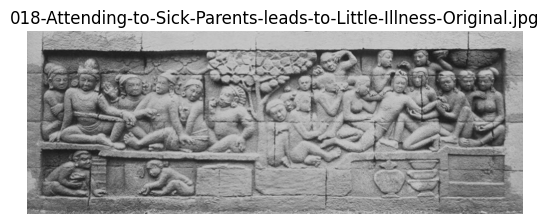

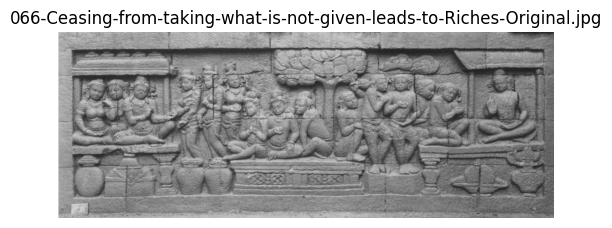

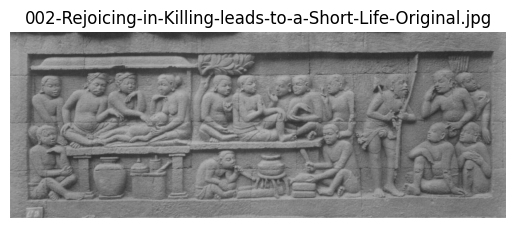

In [65]:
# testing
def preprocess_query_image(img_path, target_size=image_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

query_img_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/image all/018-Attending-to-Sick-Parents-leads-to-Little-Illness-Original.jpg'
query_img = preprocess_query_image(query_img_path)
query_feature = model.predict(query_img)

indices, scores = find_similar_images(query_feature, features, top_k=3)
print("Top 3 similar images:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {image_names[idx]} with similarity score: {scores[i]:.4f}")

# Tampilkan gambar yang relevan
for idx in indices:
    img_path = os.path.join(IMAGE_DIR, image_names[idx])
    img = load_img(img_path)
    plt.imshow(img)
    plt.title(image_names[idx])
    plt.axis('off')
    plt.show()

## Membuat dictionary narasi

Mapping Narasi/load data narasi karmawibhangga dan menyimpan dalam struktur dictionary

In [78]:
narrative_dict = {}

for _, row in df_narasi.iterrows():
    narrative_dict[row['filename']] = {
        'tema': row['Tema'],
        'narasi': row['Narasi'],
        'makna_moral': row['Makna moral']
    }

In [79]:
# Check apakah struktur mapping sudah benar atau belum. Lihat 3 item pertama
for filename, content in list(narrative_dict.items())[:3]:
    print(f"Filename: {filename}")
    if isinstance(content, dict):
        print(f"Tema       : {content.get('tema')}")
        print(f"Narasi     : {content.get('narasi')}")
        print(f"Makna Moral: {content.get('makna_moral')}")
    else:
        # Jika hanya narasi saja
        print(f"Narasi     : {content}")
    print("-" * 50)

Filename: 001-Killing-Living-Beings-Original.jpg
Tema       : Pembunuhan
Narasi     : Di sebuah desa nelayan, sekelompok orang tengah bersuka cita. Para nelayan sibuk menyiapkan jebakan mereka di laut, berharap hasil tangkapan yang melimpah. Di sisi lain, para pemusik memainkan alat musik dengan riang, seolah mendukung kegiatan itu sebagai sebuah hiburan. Seorang tokoh terkemuka berdiri memuji para nelayan, menyebutnya sebagai kerja keras yang patut diapresiasi. Di tengah keramaian itu, seseorang membawa hasil tangkapan dengan bangga, menunjukkan keberhasilan mereka hari itu. Namun, di balik suasana yang tampak penuh kegembiraan, tersembunyi kenyataan bahwa makhluk-makhluk hidup telah kehilangan nyawa demi kepuasan manusia. Mereka tidak menyadari bahwa turut bersenang-senang dalam pembunuhan, bahkan hanya sebagai penonton, tetap meninggalkan jejak karma. Relief ini tidak menunjukkan akibatnya secara langsung, tetapi dalam ajaran Buddha, membunuh makhluk hidup, sekecil apa pun, membawa 

In [71]:
print(f"Jumlah narasi: {len(narrative_dict)}")

Jumlah narasi: 160


In [76]:
# Simpan dalam bentuk JSON
with open('narrative_dict.json', 'w', encoding='utf-8') as f:
    json.dump(narrative_dict, f, ensure_ascii=False, indent=2)